In [558]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jdatetime as jd


Read data






In [559]:
input_data=pd.read_csv("weather.csv", header=4)
#input_data
#input_data.info()
#input_data.describe()

Pre Processing

In [560]:
def auto_data_type(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        min_value = df[col].min()
        max_value = df[col].max()

        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32)
        elif min_value >= 0:
            if max_value <= 255:
                df[col] = df[col].astype(np.uint8)
            elif max_value <= 65535:
                df[col] = df[col].astype(np.uint16)
            elif max_value <= 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if -128 <= min_value and max_value <= 127:
                df[col] = df[col].astype(np.int8)
            elif -32768 <= min_value and max_value <= 32767:
                df[col] = df[col].astype(np.int16)
            elif -2147483648 <= min_value and max_value <= 2147483647:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
    return df


reduced_data=auto_data_type(input_data)
reduced_data["sunrise (iso8601)"] = pd.to_datetime(reduced_data["sunrise (iso8601)"]).dt.strftime("%H:%M")
reduced_data["sunset (iso8601)"] = pd.to_datetime(reduced_data["sunset (iso8601)"]).dt.strftime("%H:%M")

reduced_data["daylight_duration (s)"]=(reduced_data["daylight_duration (s)"]/60).astype(np.uint16)





Remove out of range data

In [561]:
numeric_cols = [
    "temperature_2m_mean (°C)",
    "temperature_2m_max (°C)",
    "temperature_2m_min (°C)",
    "precipitation_sum (mm)",
    "rain_sum (mm)",
    "snowfall_sum (cm)"
]

cols = ['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)']

for col in cols:
    mean = reduced_data[col].mean()
    std = reduced_data[col].std()
    reduced_data[f"{col}_is_out_of_range"] = (reduced_data[col] < mean - 3 * std) | (reduced_data[col] > mean + 3 * std)

out_of_range_cols = [
    'precipitation_sum (mm)_is_out_of_range',
    'rain_sum (mm)_is_out_of_range',
    'snowfall_sum (cm)_is_out_of_range'
]

condition = (
    (reduced_data[out_of_range_cols[0]] == False) &
    (reduced_data[out_of_range_cols[1]] == False) &
    (reduced_data[out_of_range_cols[2]] == False)
)

cleaned_data = reduced_data[condition]

print(f"Total rows with out_of_ranges: {len(reduced_data) - len(cleaned_data)}")
print(f"Rows remaining: {len(cleaned_data)}")



# plt.boxplot(
#     reduced_data.loc[reduced_data["location_id"]==1, "precipitation_sum (mm)"],
#     labels=["Location 0"]
# )
# plt.show()


Total rows with out_of_ranges: 37
Rows remaining: 1061


Remove duplicated

In [562]:
#cleaned_data.duplicated()

Split data into cities

In [563]:
city_labels = {0: "Tehran", 1: "Qom", 2: "Rasht"}
reduced_data["city"] = reduced_data["location_id"].map(city_labels)

reduced_data_tehran = reduced_data[reduced_data["location_id"] == 0]
reduced_data_qom = reduced_data[reduced_data["location_id"] == 1]
reduced_data_rasht = reduced_data[reduced_data["location_id"] == 2]

Finding the influencing factors

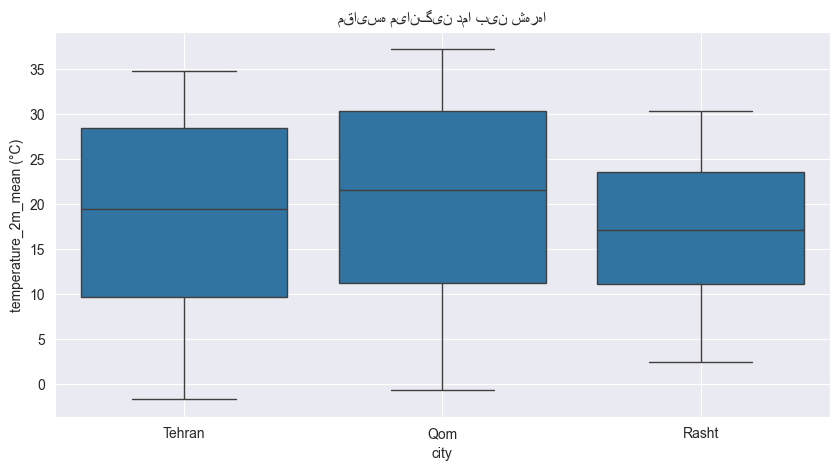

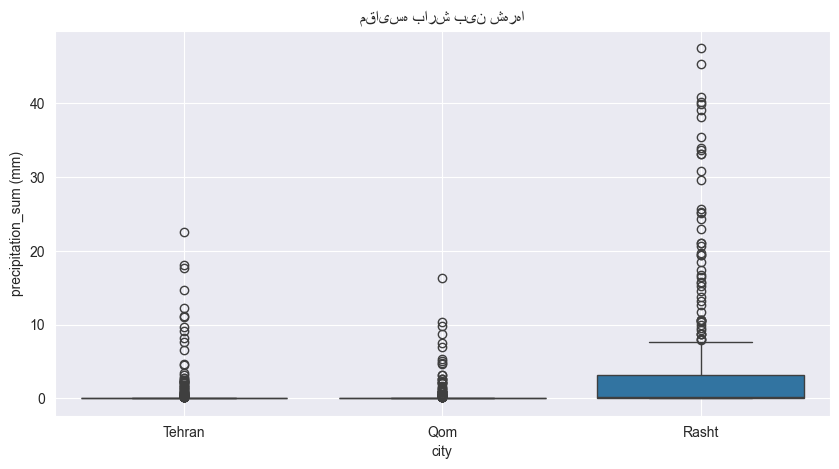

In [564]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=reduced_data, x="city", y="temperature_2m_mean (°C)")
plt.title("مقایسه میانگین دما بین شهرها")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=reduced_data, x="city", y="precipitation_sum (mm)")
plt.title("مقایسه بارش بین شهرها")
plt.grid(True)
plt.show()

<p style={text-align=right}>با توجه به نمودار های بالا ، شهر قم با میانگین دمای بالا تر، دارای بارش کمتری است. در مقابل، شهر رشت که میانگین دمای آن نسبت به قم و تهران پایین ‌تر است، بارش بیشتری را تجربه می‌کند. این موضوع نشان می ‌دهد که بین عوامل دمای هوا و میزان بارش، رابطه‌ای معکوس وجود دارد. پس می توان استنباط کرد که هرچه دما پایین ‌تر باشد، احتمال بارندگی بیشتر است. </p>
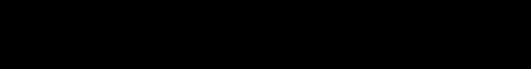
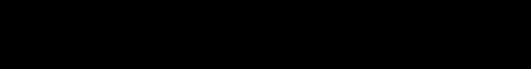

In [565]:
reduced_data["time"] = pd.to_datetime(reduced_data["time"])

def seasons_jalali(date):
    jdate = jd.date.fromgregorian(date=date)
    if jdate.month in [1, 2, 3]:
        return 'spring'
    elif jdate.month in [4, 5, 6]:
        return 'summer'
    elif jdate.month in [7, 8, 9]:
        return 'fall'
    else:
        return 'winter'

reduced_data["season"] = reduced_data["time"].map(seasons_jalali)
reduced_data["time"] = pd.to_datetime(reduced_data["time"])


Analysis

In [566]:
cities = reduced_data["city"].unique().tolist()

season_names = {
    "spring": "بهار",
    "summer": "تابستان",
    "fall": "پاییز",
    "winter": "زمستان"
}

reduced_data["time"] = pd.to_datetime(reduced_data["time"])
results = []

for season_en, season_fa in season_names.items():
    season_data = reduced_data[reduced_data["season"] == season_en]
    season_data = season_data[season_data["precipitation_sum (mm)"] > 0]
    season_data = season_data.sort_values("time")

    events = []

    for date in season_data["time"].unique():
        daily_data = season_data[season_data["time"] == date]
        for city in daily_data["city"].unique():
            events.append((date, city))

    events.sort()

    all_sequences = []
    for i in range(len(events)):
        visited_cities = [events[i][1]]
        for j in range(i + 1, len(events)):
            if events[j][1] not in visited_cities:
                visited_cities.append(events[j][1])
            if len(visited_cities) == 3:
                all_sequences.append(tuple(visited_cities))
                break

    if all_sequences:
        unique_sequences = list(set(all_sequences))
        sequence_counts = [all_sequences.count(seq) for seq in unique_sequences]
        best_seq = unique_sequences[sequence_counts.index(max(sequence_counts))]
        results.append((season_fa, " → ".join(best_seq)))
    else:
        results.append((season_fa, "الگوی مشخصی پیدا نشد"))


for season, seq in results:
    print(f"{season:<10} | {seq}")


بهار       | Rasht → Tehran → Qom
تابستان    | الگوی مشخصی پیدا نشد
پاییز      | Rasht → Tehran → Qom
زمستان     | Rasht → Tehran → Qom
